# Audio Waves

I'll discuss some findings here, relevant for later:
- It is quite obvious, but still: we should be careful when plotting the frequency spectrum in the gif: the more narrow we make the time fragment being analyzed, the more frequencies we will be losing in the graphic.
- An easy way to make different graphics out of already existing ones is, if they revolve around zero (such as the audio wave itself) is applying an absolute value function to them.
- In cases where there is too much of a difference between values (some too high compared to some too low), we may want to apply a damping function, such as an sqrt or log. However there's we should keep in mind with these functions: they will pump up small, near-zero fluctuations making them relevant:
 $$
 \sqrt x > x,\iff x < 1,\qquad |\log(x)| > x,\iff x \gtrsim 0
 $$
For this reason, it may be interesting to define piece-wise counterparts such as 
$$
piecesqrt(x) = \left\{
        \begin{array}{ll}
            x & \quad x \leq 1 \\
            \sqrt x & \quad x \geq 1
        \end{array}
    \right.
$$
$$
piecelog(x) = \left\{
        \begin{array}{ll}
            x & \quad x \leq 1 \\
            \log(x) & \quad x \geq 1
        \end{array}
    \right.
$$


In [1]:
# define the audio input
speech="audiolimpio.wav"

## 1) Processing Audio

In [2]:
import wave
import numpy as np

In [3]:
with wave.open(speech,'r') as spf: 
    sound_info = spf.readframes(-1)
    sound_info = np.frombuffer(sound_info, int)
    
    nframes = spf.getnframes() # number of frames
    frate = spf.getframerate() # frames per second

In [4]:
print(sound_info)

[  844450700197892  1407409243488264   844450700263430 ...
 -1688892810395657 -1407417833553931 -1125929971875849]


In [5]:
len(sound_info)

193974

In [6]:
print(frate) 
print(nframes)
length = nframes/float(frate)
print(length) # length

44100
775896
17.59401360544218


In [7]:
onesec_info = round(len(sound_info)/length)

## 2) Drawing Audio Wave

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

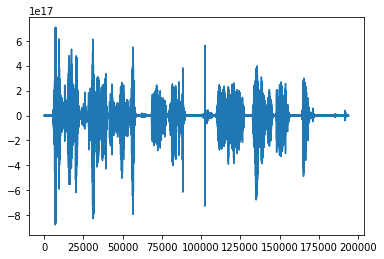

In [9]:
# Plot full soundwave
plt.plot(sound_info)

### 2.5) Drawing Audio Gif

In [10]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc

In [17]:
rc('animation', html='html5')

fig, ax = plt.subplots()
ylim = max(abs(sound_info)) * 1.1

mod = 10 # from 1 to length

def animate(i):
    ax.cla()
    ax.set_ylim(-ylim,ylim)
    ax.set_axis_off()
    
    current = (int(i * onesec_info/ mod),int((i + 1) * onesec_info / mod))
    ax.plot(sound_info[current[0]:current[1]],lw=0.1)
    

frames = int(length) * mod
ani = FuncAnimation(fig, animate, frames=frames, interval = 1000/mod, repeat=False)
plt.close()

In [18]:
ani

Note: when removing axis with set_axis_off(), the line width increases for some reason. I find it convenient to set it to lw = 0.1 in that case.

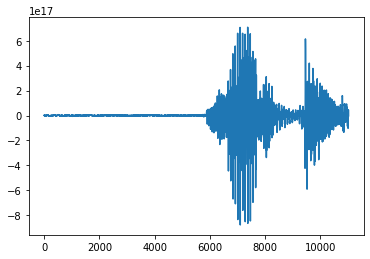

In [13]:
plt.plot(sound_info[0:onesec_info * 1]) # first second

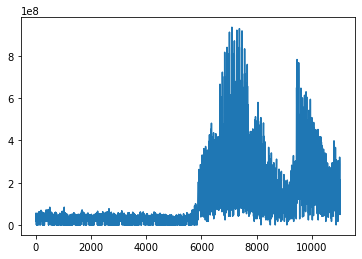

In [14]:
#plt.plot(np.abs(sound_info[0:onesec_info * 1])) # absolute value
plt.plot(np.sqrt(np.abs(sound_info[0:onesec_info * 1]))) # sqrt of the absolute value

## 3) Drawing spectrums

In [15]:
import spectrum

In [16]:
freq = spectrum.speriodogram(sound_info[:onesec_info]) # this is the frequency spectrum
print(freq)

[9.91607440e+35 6.38882298e+35 8.00210038e+33 ... 1.53627533e+33
 9.22180547e+33 1.81788627e+33]


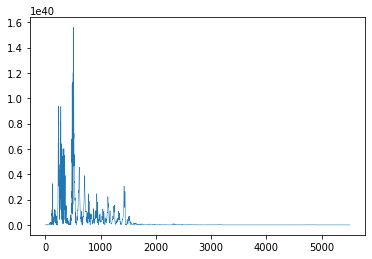

In [17]:
plt.plot(freq, lw=0.5)

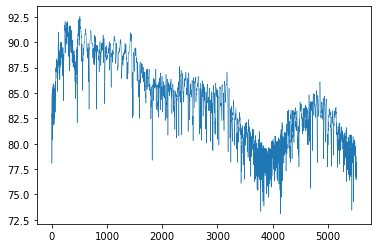

In [18]:
# this is the power spectrum, Log(freq)
#spectrum.Periodogram(sound_info[:onesec_info]).plot() 
plt.plot(np.log(freq), lw=0.5)
plt.grid(False)

[9.9160744  6.38882298 0.080021   ... 0.01536275 0.09221805 0.01817886]


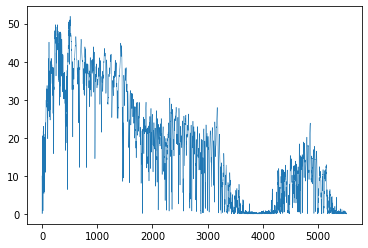

In [19]:
freqnorm = freq/1E+35
print(freq/1E+35)
datt = np.piecewise(freqnorm, [freqnorm < 1, freqnorm >= 1], [lambda freqnorm: freqnorm, lambda freqnorm: 10 * np.log10(freqnorm)])
plt.plot(datt,lw=0.5)

In [46]:
# no clue what this is, check https://pyspectrum.readthedocs.io/en/latest/ref_fourier.html#spectrum.periodogram.Periodogram
Welfreq = spectrum.WelchPeriodogram(sound_info[:onesec_info]) # this is the frequency spectrum
plt.close()
#Welfreq
#print(4*np.log(Welfreq[0][0]))

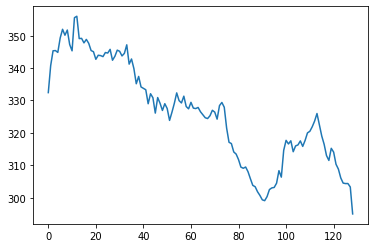

In [29]:
#plt.plot(Welfreq[0][1],10*np.log10(Welfreq[0][0]))
plt.plot(10*np.log10(Welfreq[0][0]))

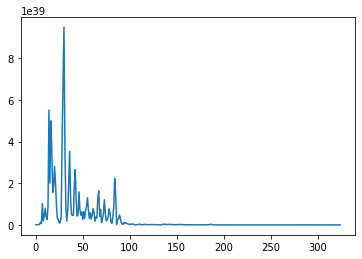

In [22]:
# This is a P-nearest-averaged spectrum. 
Danfreq = spectrum.DaniellPeriodogram(sound_info[:onesec_info],8) # this is the frequency spectrum
#print(Danfreq[0])
plt.plot(Danfreq[0])

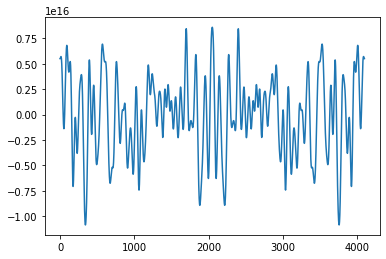

In [23]:
# no idea. A symmetric spiky wave, for all I know.
# higher lag = less spikes (lag=1 means Gauss bell). less length = less spikes, Less info?
CORRfreq = spectrum.CORRELOGRAMPSD(sound_info[:round(onesec_info/1)], lag=100)
#print(CORRfreq)
plt.plot(CORRfreq)

In [24]:
Foufreq = spectrum.FourierSpectrum(sound_info[:round(onesec_info/1)], lag=32, sampling=1024, NFFT=512)
#print(Foufreq)
#plt.plot(Foufreq.data)
#plt.plot(Foufreq)
#Foufreq.plot(norm=True)

### 3.5) Drawing spectrum gif

In [49]:
# Setup
rc('animation', html='html5')

fig, ax = plt.subplots()
#freq_tot = spectrum.speriodogram(sound_info)
#ylim = max(freq_tot) * 1.1 #this doesn't work well. 
ylim = 1e+40

mod = 10 # from 1 to length

types = ['spec', 'log', 'sqrt', 'Welch', 'Daniell', 'CORR','CYOA']

plot = types[2]

P = 8 # For the DaniellPeriodogram
lag = 100 # For Correlogram
absval = True # For those with values revolving around 0
piece = False # For piecewise log or sqrt
fill = True # For filling the area under curve

plt.close()

In [50]:
def animate(i):
    ax.cla()
    #ax.set_xlim()
    ax.set_axis_off()

    current = (int(i * onesec_info/ mod),int((i + 1) * onesec_info / mod))

    if plot == 'spec':
        freq = spectrum.speriodogram(sound_info[current[0]:current[1]])
        ax.set_ylim(-1e+39,ylim)

    elif plot == 'log':
        freq = spectrum.speriodogram(sound_info[current[0]:current[1]])
        #ax.set_ylim(65,100)
        if not piece:
            freq = 10*np.log10(freq)
        else:
            freq = np.piecewise(freq, [freq < 1, freq >= 1], [lambda freq: freq, lambda freq: 10 * np.log10(freq)])

    elif plot == 'sqrt':
        freq = spectrum.speriodogram(sound_info[current[0]:current[1]])
        if not piece:
            freq = np.sqrt(freq)
        else:    
            freq = np.piecewise(freq, [freq < 1, freq >= 1], [lambda freq: freq, lambda freq: np.sqrt(freq)])            
    
    elif plot == 'Welch':
        freq = spectrum.WelchPeriodogram(sound_info[current[0]:current[1]]) 
        freq = 10*np.log10(freq[0][0])
        
    elif plot == 'Daniell':
        freq = spectrum.DaniellPeriodogram(sound_info[current[0]:current[1]],P = P)[0]
    
    elif plot == 'CORR':
        freq = spectrum.CORRELOGRAMPSD(sound_info[current[0]:current[1]], lag = lag) 
        if absval:
            freq = np.abs(freq)
    
    elif plot == 'CYOA':
        # Choose Your Own Adventure #
        func = lambda f : np.multiply(f, np.cos(f))
        freq = spectrum.speriodogram(sound_info[current[0]:current[1]])
        freq = func(freq)
        if absval:
            freq = np.abs(freq)
        
    ax.plot(freq, lw=0.1)
    if fill:
        ax.fill_between(range(len(freq)), freq, color='red', alpha=0.3)


frames = int(length) * mod
ani = FuncAnimation(fig, animate, frames=frames, interval = 1000/mod, repeat=False)


In [51]:
ani

Same comment regarding the line width as before.

To do: in order to plot the area under curve, we should find the lowest value. In most spectrograms this is far from zero, and thus needs to be computed beforehand. The same goes for the range, should we want to fix it for better appearance.